**TP KNN, discrimination linéaire et régression logistique**
--
**Variations autour de la frontière de décision**
<br><br>Mita RAKOTONIAINA, Master spécialisé BGD, <br>Anaële BAUDANT-COJAN, Master spécialisé IA, 
<br><br>Apprentissage statistique et fouille de données (IABGD 703), Telecom Paris
<br>Paris, le 22 décembre 2023

# Packages

In [1]:
import matplotlib.pyplot as plt
from math import fmod
from tp_knn_source import *
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

# Génération artificielle de données

## 1. Études des fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers.

Brève description des fonctions à générer : 

- **Fonction rand_bi_gauss:** sert à générer des données provenant de deux variables gaussiennes bidimensionnelles. Elle prend en paramètre le nombre d'observations de chaque classe (n1 et n2), leur moyenne (mu1 et mu2) et leur écart-type (sigma1 et sigma2). Elle retourne les labels associés à chaque observation (1 ou -1).

- **Fonction rand_tri_gauss:** c'est comme la première fonction mais avec trois variables et elle retourne les labels associés à chaque observation (1, 2 ou 3).

- **Fonction rand_clown:** C'est comme la première fonction mais elle sert à générer des données en forme de "clown" pour deux classes.

- **Fonction rand_checkers:** C'est la troisième fonction mais elle génère des données en forme de "damier" pour deux classes.

### Les différentes fonctions

In [2]:
def rand_gauss(n=100, mu=[1, 1], sigma=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigma + mu)

def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1], sigmas2=[0.1, 0.1]):
    """Sample n1 and n2 points from two Gaussian distributions with centers mu1 and mu2, and standard deviations sigmas1 and sigmas2."""
    X = np.vstack([rand_gauss(n1, mu1, sigmas1), rand_gauss(n2, mu2, sigmas2)])
    y = np.hstack([np.ones(n1), -np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1], mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1], sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """Sample n1, n2, and n3 points from three Gaussian distributions centered at mu1, mu2, and mu3 with standard deviations sigma1, sigma2, and sigma3."""
    X = np.vstack([rand_gauss(n1, mu1, sigma1), rand_gauss(n2, mu2, sigma2), rand_gauss(n3, mu3, sigma3)])
    y = np.hstack([np.ones(n1), 2 * np.ones(n2), 3 * np.ones(n3)])
    ind = np.random.permutation(n1 + n2 + n3)
    return X[ind, :], y[ind]

def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind] 

def rand_checkers(n1=100, n2=100, sigma=0.1):
    """Sample n1 and n2 points from a noisy checkerboard pattern."""
    nbp = int(n1 / 8)
    nbn = int(n2 / 8)
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            nb = nbp if (i + j) % 2 == 0 else nbn
            yapp[idx:idx + nb] = ((i + j) % 3 + 1) * np.ones(nb)
            xapp[idx:idx + nb, 0] += i + sigma * np.random.randn(nb)
            xapp[idx:idx + nb, 1] += j + sigma * np.random.randn(nb)
            idx += nb
    ind = np.random.permutation((nbp + nbn) * 8)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return res[ind, :2], res[ind, 2]

### Fonction de Représentation graphique

In [3]:
# Liste des symboles utilisés pour le tracé des points
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']

def plot_2d(ax, data, y=None, alpha_choice=1):
    k = np.max([np.unique(y).shape[0], 1])
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        ax.scatter(data[:, 0], data[:, 1], s=80, marker=symlist[0])
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == lab)[0] for lab in labs]
        for i, idx in enumerate(idxbyclass):
            ax.scatter(data[idx, 0], data[idx, 1], c=np.reshape(color_blind_list[i], (1, -1)), s=80, marker=symlist[i % len(symlist)], label=f"Class {int(labs[i])}")
    ax.set_ylim([np.min(data[:, 1]) - 1, np.max(data[:, 1]) + 1])
    ax.set_xlim([np.min(data[:, 0]) - 1, np.max(data[:, 0]) + 1])
    if y is not None:
        ax.legend()

### Appel des fonctions

In [4]:
X1, y1 =rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],sigmas2=[0.9, 0.9])

X2, y2 =rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1], mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9], sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

X3, y3 = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)

X4, y4 = rand_checkers(n1=150, n2=150, sigma=0.1)

In [5]:
print('X1',X1.shape,y1.shape)
print('X2',X2.shape,y2.shape)
print('X3',X3.shape,y3.shape)
print('X4',X4.shape,y4.shape)

X1 (40, 2) (40,)
X2 (150, 2) (150,)
X3 (100, 2) (100,)
X4 (288, 2) (288,)


## 2. Représentation graphique des fonctions

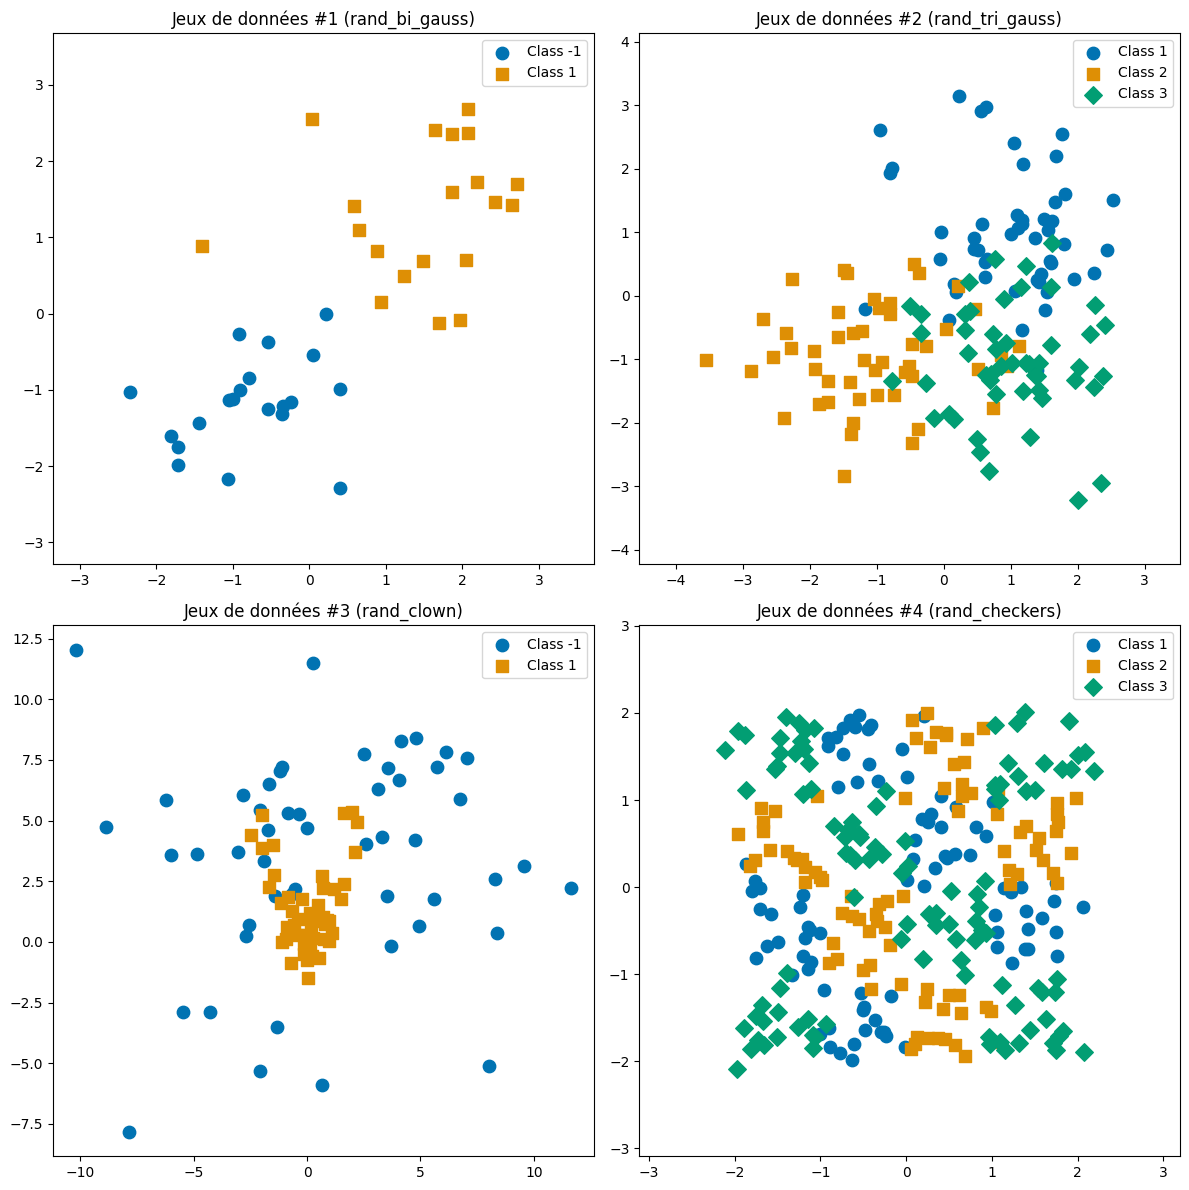

In [6]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Crée une figure et une grille 2x2 d'axes

# Tracer les données sur les sous-graphiques appropriés
plot_2d(axs[0, 0], X1, y1)  # Tracé sur le premier sous-graphique en haut à gauche
axs[0, 0].set_title('Jeux de données #1 (rand_bi_gauss)')

plot_2d(axs[0, 1], X2, y2)  # Tracé sur le deuxième sous-graphique en haut à droite
axs[0, 1].set_title('Jeux de données #2 (rand_tri_gauss)')

plot_2d(axs[1, 0], X3, y3)  # Tracé sur le troisième sous-graphique en bas à gauche
axs[1, 0].set_title('Jeux de données #3 (rand_clown)')

plot_2d(axs[1, 1], X4, y4)  # Tracé sur le quatrième sous-graphique en bas à droite
axs[1, 1].set_title('Jeux de données #4 (rand_checkers)')

# Ajustement automatique de la disposition pour éviter le chevauchement
plt.tight_layout()

# Approche intuitive

## 3. Version adaptée de cette méthode pour la régression

En régression, l'algorithme des k-plus proches voisins prédit une valeur continue pour un nouveau point en se basant sur les valeurs des voisins les plus proches. Au lieu de choisir la classe la plus commune, on calcule soit la moyenne, soit la médiane des valeurs de ces voisins. La moyenne est simple et efficace, mais la médiane peut mieux résister aux valeurs aberrantes. Une autre méthode est la moyenne pondérée par la distance, qui donne plus de poids aux voisins plus proches, offrant une prédiction potentiellement plus précise pour le nouveau point. 

# Approche formelle

## 4.Classifieur k-plus proches voisins avec données #2

In [7]:
# Classifieur k-plus proches voisins 
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    
    def __init__(self, n_neighbors=1):
        # Initialisation de la classe
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        # Entraînement du modèle sur les vecteurs des variables explicatives (X) et à expliquer (y)
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        # Déclaration du vecteur de prédictions
        predictions = []

        for x in X:
            # Calcul des distances
            distances = np.linalg.norm(self.X_train - x, axis=1)

            # Indices des k-plus proches voisins
            indices = np.argsort(distances)[:self.n_neighbors]
            
            # Classes des k-plus proches voisins
            neighbors_classes = self.y_train[indices]

            # Gestion des ex-æquo en utilisant le choix aléatoire
            if len(np.unique(neighbors_classes)) == 1:
                # Choix aléatoire parmi les classes égales
                predicted_class = np.random.choice(neighbors_classes)
            else:
                # Choix de la classe majoritaire en cas de non-ex æquo
                predicted_class, _ = mode(neighbors_classes)
                
            # Ajout dans le vecteur à la fin de chaque itération
            predictions.append(predicted_class)

        return np.array(predictions)

In [17]:
# On utilise le jeu de données #2
X, y = X2, y2

# Séparation des données en ensembles d'apprentissage et de test
# Utilisation des observations d'indice pair pour l'apprentissage
X_train = X[::2] 
y_train = y[::2]

# Utilisation des observations d'indice impair pour le test
X_test = X[1::2]  
y_test = y[1::2]

# Utilisation de la classe définie précédemment KNNClassifier
knn_custom = KNNClassifier(n_neighbors=3)
knn_custom.fit(X_train, y_train)
y_pred_custom = knn_custom.predict(X_test)
# Utilisation de la classe KNeighborsClassifier de scikit-learn
knn_sklearn = KNeighborsClassifier(n_neighbors=3)
knn_sklearn.fit(X_train, y_train)
y_pred_sklearn = knn_sklearn.predict(X_test)

# Comparaison des résultats entre les deux classes
accuracy_custom = np.mean(y_pred_custom == y_test)
accuracy_sklearn = np.mean(y_pred_sklearn == y_test)

print(f"Accuracy (Homemade KNN): {accuracy_custom}")
print(f"Accuracy (Scikit-learn KNN): {accuracy_sklearn}")
print(f"Predictions strictly equivalent (Homemade vs Scikit-learn): {y_pred_custom.all() ==y_pred_sklearn.all()}")
good_pred=(y_pred_custom == y_pred_sklearn).sum()/len(y_pred_custom)*100
print(f"% strictly equivalent predictions : {good_pred}%")

Accuracy (Homemade KNN): 0.7466666666666667
Accuracy (Scikit-learn KNN): 0.7466666666666667
Predictions strictly equivalent (Homemade vs Scikit-learn): True
% strictly equivalent predictions : 100.0%


100.0


On a un taux d'accuracy qui est équivalent entre ces deux méthodes de KNN (celle que nous avons codé, et celle de Scikit-learn). Dans notre example, les prédictions sont cohérentes pour 81,33% des points dans notre échantillon test. L'accuracy varie entre 75% et 83% selon les données générées aléatoirement pour X2. 

Les 2 méthodes de classification "Homemade KNN" et "Scikit-learn KNN" sont strictement equivalentes dans leur prédiction. Il pourrait y avoir une très légère différence en cas de classes ex aequo, puisque la classe prédite est tirée au sort dans ce cas avec Homemade KNN. Avec le choix de l'hyperparametre de 3 voisins le plus proches, et 3 classes, cela signiefierait qu'un point est entouré d'un point de chaque classe.


## 5. Tourner sur les quatre exemples de jeu de données cet algorithme de classification

### Jeu de données #1 (Bi-gaussian)

Accuracy sur les données d'entrainement: 0.96875
Accuracy sur les données de test: 0.875


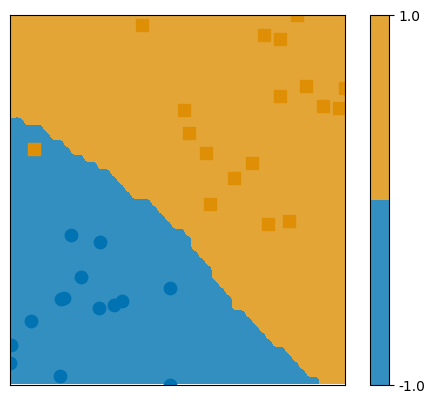

In [23]:
# Standartisation avec StandardScaler de scikit-learn
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Partage des données entre train et test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.2, random_state=44)

# Création et entraînement du modèle kNN sur nos données d'entraînement
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X1_train, y1_train)
print("Accuracy sur les données d'entrainement:",knn_classifier.score(X1_train, y1_train))
print("Accuracy sur les données de test:",knn_classifier.score(X1_test, y1_test))

# Définition de la fonction de décision
def decision_function(X1):
    return knn_classifier.predict(X1.reshape(-1,2))

# Affichage de la frontière de décision avec la fonction frontiere_new
frontiere_new(decision_function, X1_train.reshape(-1,2), y1_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

# Affichage du graphique
plt.show()

Les données sont bien séparées par le classificateur, avec une frontière relativement simple et plutot linéaire, indiquant une bonne performance du modèle sur ces données. Il y a un léger chevauchement des classes dans la zone de frontière, ce qui est attendu en raison de la proximité des distributions et de l'accuracy.

### Jeu de données #2 (Tri-gaussian)

Accuracy sur les données d'entrainement: 0.8833333333333333
Accuracy sur les données de test: 0.7666666666666667


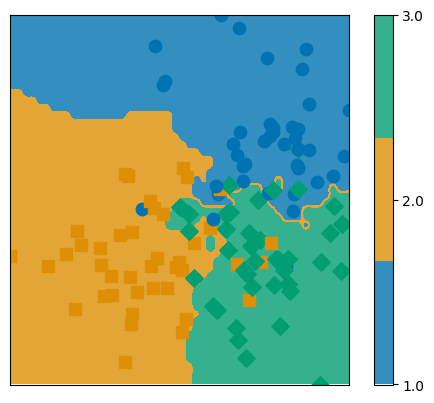

In [25]:
# même démarche pour les jeux de données 1
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.2, random_state=44)

knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X2_train, y2_train)
print("Accuracy sur les données d'entrainement:",knn_classifier.score(X2_train, y2_train))
print("Accuracy sur les données de test:",knn_classifier.score(X2_test, y2_test))

def decision_function(X2):
    return knn_classifier.predict(X2.reshape(-1, 2))

frontiere_new(decision_function, X2_train.reshape(-1, 2), y2_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

plt.show()

C'est comme dans les deux labels, on peut voir ici une nette discrimination mais avec des petites erreurs de classifications.

Les données sont plus entremélées, et la frontière de décision décrit des circonvolutions.

### Jeu de données #3 (Clown)

Accuracy sur les données d'entrainement: 0.8875
Accuracy sur les données de test: 0.75


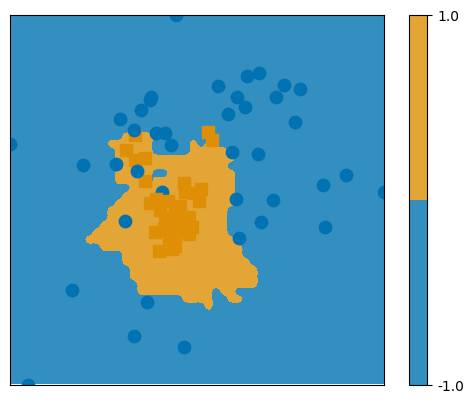

In [28]:
# Analogiquement, on a : 
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y3, test_size=0.2, random_state=44)

knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X3_train, y3_train)
print("Accuracy sur les données d'entrainement:",knn_classifier.score(X3_train, y3_train))
print("Accuracy sur les données de test:",knn_classifier.score(X3_test, y3_test))

def decision_function(X3):
    return knn_classifier.predict(X3.reshape(-1, 2))

frontiere_new(decision_function, X3_train.reshape(-1, 2), y3_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

plt.show()

L'espace de caractéristiques est principalement dominé par une classe (en bleu), avec une région isolée (en orange) représentant une seconde classe. 

La frontière entre les deux classes est clairement définie bien que légèrement irrégulière.  La présence d'une seule zone orange suggère une concentration locale de points d'une autre classe au sein d'une classe majoritaire

### Jeu de données #4 (Checkers)

Accuracy sur les données d'entrainement: 0.908695652173913
Accuracy sur les données de test: 0.7413793103448276


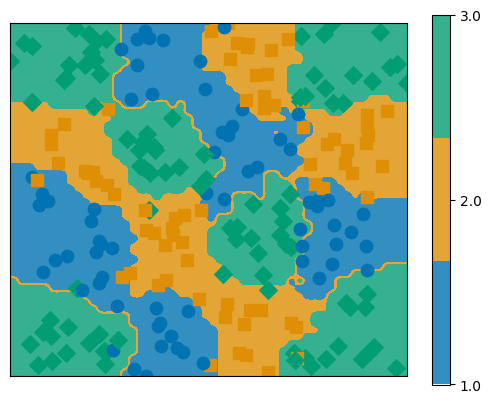

In [29]:
# On standardise les données grâce à la méthode StandardScaler de scikit-learn
scaler = StandardScaler()
X4_scaled = scaler.fit_transform(X4)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4_scaled, y4, test_size=0.2, random_state=44)

# Création et entraînement du modèle kNN sur nos données d'entraînement
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X4_train, y4_train)
print("Accuracy sur les données d'entrainement:",knn_classifier.score(X4_train, y4_train))
print("Accuracy sur les données de test:",knn_classifier.score(X4_test, y4_test))

# Définition de la fonction de décision
def decision_function(X4):
    return knn_classifier.predict(X4.reshape(-1, 2))

# Affichage de la frontière de décision avec la fonction frontiere_new
frontiere_new(decision_function, X4_train.reshape(-1, 2), y4_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

# Affichage du graphique
plt.show()

Le graphique illustre la cartographie des prédictions d'un classificateur kNN pour un ensemble de données à trois classes. Les régions en bleu, orange et vert correspondent aux zones où le modèle prédit respectivement chacune des trois classes. La qualité des prédictions est du KNN est très bonne, compte tenu de la complexité des données sous jacentes.

Les contours irréguliers de ces régions reflètent la sensibilité du classificateur aux variations locales dans l'espace des caractéristiques. La répartition mixte des points suggère une certaine superposition dans la distribution des classes. Les frontières qui indiquent que le modèle distingue finement entre les classes là où les caractéristiques se chevauchent. La présence de points de différentes formes indique  un mélange de données d'entraînement et de test. Elles ont une prédiction précise pour la plupart des points de test qui se situent bien dans les régions prédites pour leurs classes.

## 6. Analyse de la complexité de la séparation

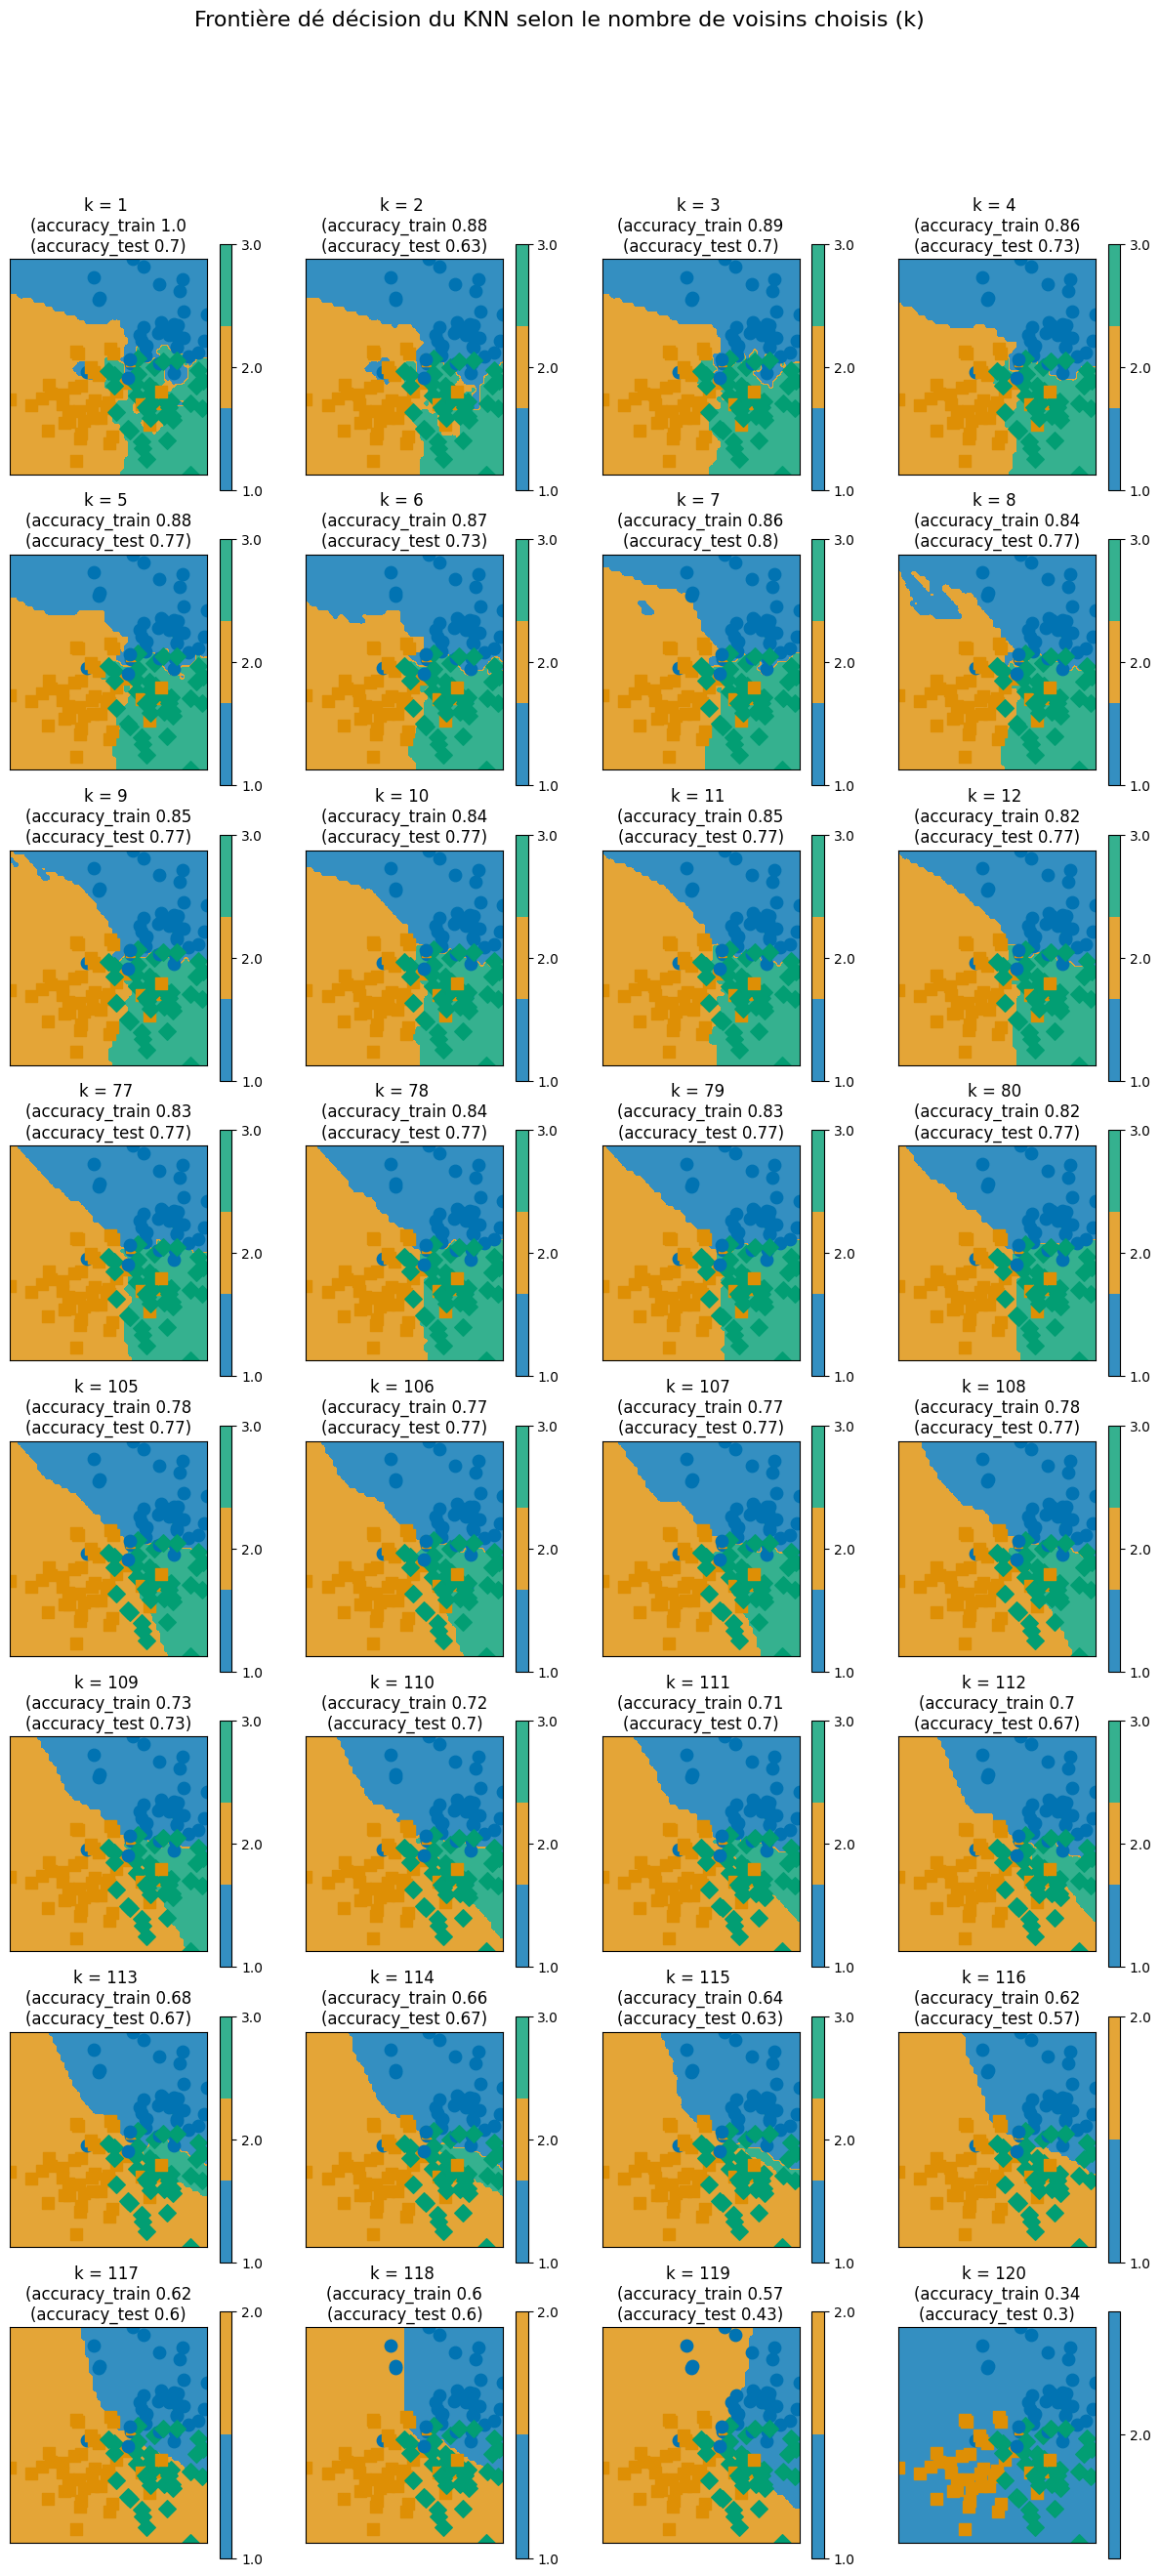

In [76]:
# Création d'un modèle kNN avec différentes valeurs de k
k_values = list(range(1, 13))
n=len(y2_train)
k_values+=list(range(n-3-40,n+1-40))
k_values+=list(range(n-3-12,n+1))

plt.figure(figsize=(15, 30))

for i, k in enumerate(k_values):
    plt.subplot(8, 4, i + 1)
    
    # Création et entraînement le modèle kNN sur nos données d'entraînement (observations d'indice pair)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X2_train, y2_train)
    
    # Affichage de la frontière de décision
    frontiere_new(lambda x: knn.predict([x]), X2_train, y2_train)
    accuracy_train=np.round(knn.score(X2_train, y2_train),2)
    accuracy_test=np.round(knn.score(X2_test, y2_test),2)
    plt.title(f'k = {k} \n(accuracy_train {accuracy_train}\n(accuracy_test {accuracy_test})')

# Affichage des graphiques    
plt.suptitle("Frontière dé décision du KNN selon le nombre de voisins choisis (k)", fontsize=16)
#plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

L'analyse des graphiques montre l'effet de la variation du paramètre k dans l'algorithme des k-plus proches voisins (KNN). Il y a 120 points dans l'échantillon d'entrainement (n=120)

### Cas k très faible : 
Avec un k faible (comme k=1), la frontière de décision est très complexe (beaucoup de circonvolution) et prédit correctement les 3 classes (meme si l'accuracy s'amméliore sur les données test à partri de k>5). En effet, Le modèle KNN considère le voisin le plus proche pour faire une prédiction dans ce cas. En d'autres termes, la frontière de décision devient très complexe car elle tien compte de chaque point de l'échantillon d'entrainement et conduit vraisemblablement à un surajustement (overfitting). CEla se retrouve dans une accuracy sur les donnée d'entrainement bien supérieure à l'accuracy sur les données de test.

### Cas 0 << k << n :
Pour un nombre k faible entre 8 et 12, la frontière de décision se "lisse" et prédit correctement les 3 classes. L'accuracy est maximale pour les données d'entrainement et les données de test. Elle tient compte d'un nombre plus important de points, ce qui stabilise les prédictions proches de la frontière. L'accuracy sur les valeur test est optimale et stable. 

### cas k tres grand :
Dès que k devient proche de n, il devient difficile de maintenir les 3 classes dans la frontiere de décision. La classe verte commence à disparaitre nettement à partir de k= 113,elle n'est plus visible à partir de k=116, comme ne témoigne l'échelle à droite du graphique. L'accuracy chute également quand k devient très grand (k>113), pour tomber à 60% de bonnes prédictions pour k=115 (dernière valeur à prédire les 3 classes). L'erreur correspond à la fréquence de la classe qui n'est plus prédite et aux erreurs sur la frontière.

### Cas k = n :
À l'autre extrême, un k égal au nombre total de points de données (n) simplifie trop la frontière de décision. Il n'y a plus qu'un seule classe qui est prédite : la classe majoritaire (ici en bleu). Cela mène à un sous-ajustement, car le modèle est trop simple (il prédit toujours la classe majoritaire). L'accuracy tombe à seulement 30% quand k=n=120 (soit la fréquence de la classe dominante)


### Conclusion
L'objectif est de trouver une valeur de k qui équilibre la complexité et la simplicité pour obtenir une bonne généralisation aux nouvelles données. Comme d'habitude, les meilleurs résultats sont obtenus en utilisant une validation croisée pour évaluer la performance du modèle sur des données non vues. Cette démarche nous permet de choisir le k qui minimise l'erreur de généralisation.

## 7. Utilisation de la variante suivante 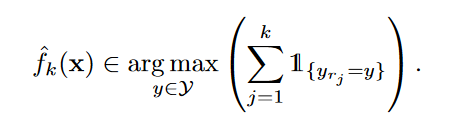

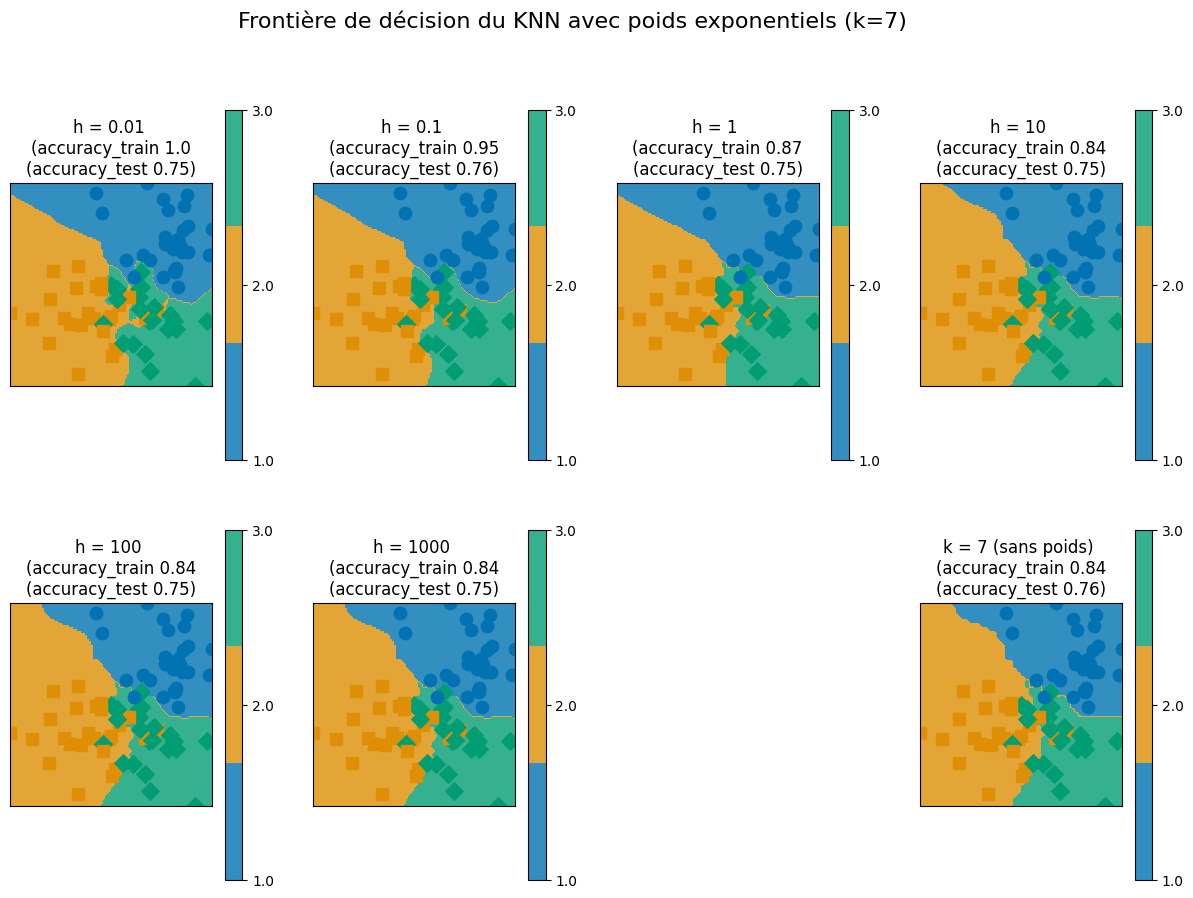

In [65]:
# Chargement des données du jeu de données #2 (observations d'indice pair pour les données d'entraînement, et d'indice impair pour les données de test)
X_train = X2[::2]
y_train = y2[::2]
X_test = X2[1::2]
y_test = y2[1::2]

# Affichage des règles de classification
plt.figure(figsize=(15, 10))

for j in range(-2, 4):
    h = 10 ** j
    
    # instanciation du modèle KNeighbors en fonction de h
    exponential_weights = lambda distances: np.exp(-distances ** 2 / h)
    knn_exponential_weighted = KNeighborsClassifier(n_neighbors=7, weights=exponential_weights)
    
    # Entraînement du modèle sur les données d'entraînement X_train et y_train
    # (observations d'indice pair)
    knn_exponential_weighted.fit(X_train, y_train)
    
    #Affichage de la frontière de décision (avec accuracy)
    plt.subplot(2, 4, j + 3)
    decision_function = lambda x: knn_exponential_weighted.predict([x])[0]
    frontiere_new(decision_function, X_train, y_train, step=100, alpha_choice=1, colorbar=True, samples=True)
    accuracy_train=np.round(knn_exponential_weighted.score(X_train, y_train),2)
    accuracy_test=np.round(knn_exponential_weighted.score(X_test, y_test),2)
    plt.title(f'h = {h} \n(accuracy_train {accuracy_train}\n(accuracy_test {accuracy_test})')

# Affichage du KNN par défault (sans poids) avec k=7
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
plt.subplot(2, 4, 8)
frontiere_new(lambda x: knn.predict([x]), X_train, y_train)
accuracy_train=np.round(knn.score(X_train, y_train),2)
accuracy_test=np.round(knn.score(X_test, y_test),2)
plt.title(f'k = 7 (sans poids) \n(accuracy_train {accuracy_train}\n(accuracy_test {accuracy_test})')



# Affichage des graphiques
plt.suptitle("Frontière de décision du KNN avec poids exponentiels (k=7)", fontsize=16)
plt.show()

Lorsque que h<1 (c'est à dire j<=0), il y a de l'over fitting, car l'accuracy sur le train est nettement supérieur à l'accuracy sur le test. Cela se voit dans la fragmentation des zones pour chaques classes (la frontière fait des circonvolutions)

Dans notre jeu de donnée, il n'y a plus de modification de la forntière de décision à partir de h>=10. La frontière de décision ne bouge plus et correspond à celle d'un KNN sans pondération. En effet, -d(j)^2/h tend vers zéro lorsque h s'agrandit, et donc notre poids exp(-d(j)^2/h) tend vers 1, donc tous les voisins ont quasiment le meme poids. Cela nous ramène vers le modèle KNN avec k=7 "sans pondération (en fait avec une pondération uniforme qui est la pondération par défault de sickit learn ou chaque voisin a le meme poids). 

Les frontières pour h=10, 100 ou 1.000 sont quasi-identiques au dernièr graphique, d'un KNN sans pondération.

## 8. Taux d'erreur

In [103]:
# Création et entraînement du modèle kNN avec un seul voisin (k=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Prédiction des étiquettes sur les données d'apprentissage (X_train)
y_pred_train = knn.predict(X_train)

# Prédiction des étiquettes sur les données de test (X_test)
y_pred_test = knn.predict(X_test)

# Calcul du taux d'erreur sur les données d'apprentissage (y_train et y_pred_train)
erreur_train = 1 - accuracy_score(y_train, y_pred_train)

# Calcul du taux d'erreur sur les données de test (y_test et y_pred_test)
erreur_test = 1 - accuracy_score(y_test, y_pred_test)

# Affichage du taux d'erreur pour les deux jeux de données (apprentissage et test)
print(f"Taux d'erreur sur les données d'apprentissage (k=1) : {erreur_train:.4f}")
print(f"Taux d'erreur sur les données de test (k=1) : {erreur_test:.4f}")

Taux d'erreur sur les données d'apprentissage (k=1) : 0.0000
Taux d'erreur sur les données de test (k=1) : 0.2533


- Lorsque **k=1**, sur les données d'apprentissage, chaque point de données est classé comme lui-même. Ce qui signifie que le taux d'erreur sur l'ensemble d'apprentissage sera de 0. Puisque le voisin le plus proche d'un point de données dans l'ensemble d'apprentissage est le point lui-même. Sur les données de test, chaque point est classé par rapport à son plus proche voisin, cela va créer des erreurs (ici 25%) à cause du bruit dans les données d'entrainement ou des données inédites dans les données de test (problème de généralisaton)

Pour ici, avec k =1, il y a donc un problème de surapprentissage car l'erreur sur l'apprentissage est nettement inférieur aux données test.

## 9. Evolution du taux d'erreur

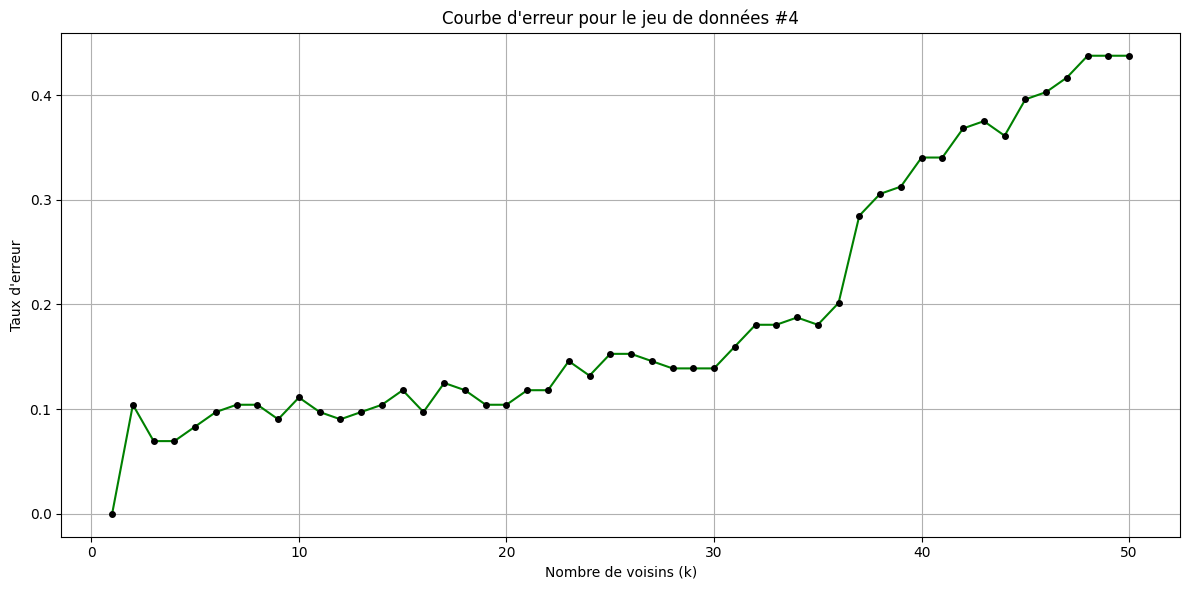

In [77]:
# Assurez-vous que X4 et y4 sont vos données réelles
X_train = X4
y_train = y4
X_test = X4[1::2]
y_test = y4[1::2]

error_rates = []

max_k = min(50, len(X_train))
for k in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred_test = knn.predict(X_test)
    erreur_test = 1 - accuracy_score(y_test, y_pred_test)
    error_rates.append(erreur_test)

plt.figure(figsize=(12, 6))

# Tracer la ligne reliant les points
plt.plot(range(1, max_k + 1), error_rates, linestyle='-', color='green')

# Mettre en évidence les points spécifiques
for i, rate in enumerate(error_rates):
    color = 'green' if rate == 0.7 else 'black'
    plt.plot(i + 1, rate, marker='.', color=color, markersize=8)

plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Taux d\'erreur')
plt.title('Courbe d\'erreur pour le jeu de données #4')
plt.xticks(range(0, max_k + 1,10))
plt.grid(True)
plt.tight_layout()
plt.show()

Le graphique montre la performance d'un modèle KNN pour différentes valeurs de k. Le meilleur résultat est obtenu pour k=3. La courbe d'erreur se stabilise autout de 10% pour k entre 2 et 20, puis s'élève jusqu'à 45% lorsque k=50. 

Rappelons que les données #4 sont le checkers, et ont été générées à partir d'un damnier de 4 cases par 4 cases, soit 16 zones. Nous avons 144 données d'entrainement, soit en moyenne 9 point par case du damnie. Les 16 zones sont réparties en 3 classes, mais  chaque point d'une case a au moins 8 voisins proche dans les données d'entrainement.

Ainsi, pour les valeurs de k proches de 9, nous avons de bons résultats, car les k voisins les plus proches vont relever de la meme case. Par contre dès que k>20, les voisins pris en compte vont relever d'autres cases, et donc potentiellement d'autres classes, ce qui abaisse l'accuracy du model. 

Ainsi, avec k compris entre 3 et 20, le modèle offre un bon équilibre entre généralisation et ajustement précis.

## 10. Courbes d'erreurs en fonctio ndu parametre k

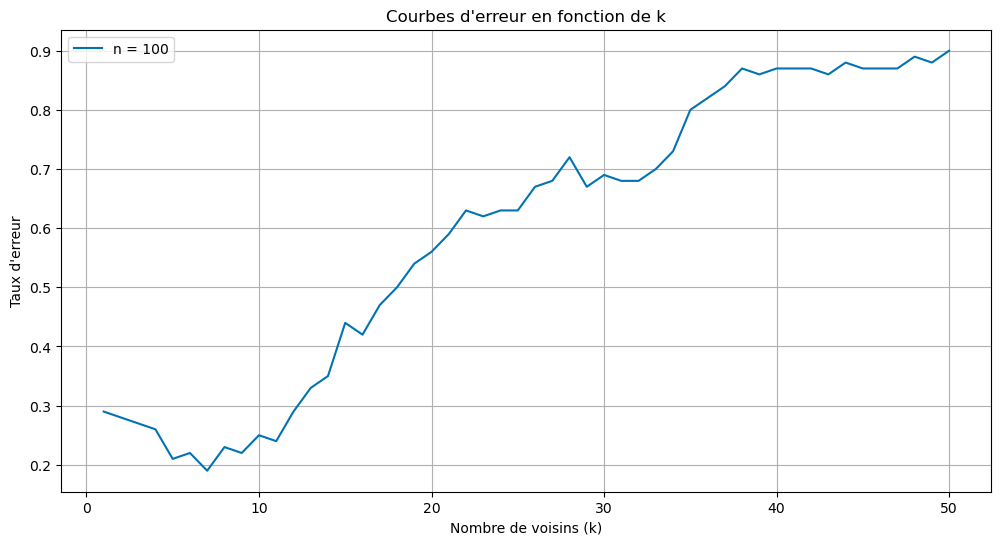

Taille de l'ensemble de données insuffisante pour n = 200
Taille de l'ensemble de données insuffisante pour n = 500
Taille de l'ensemble de données insuffisante pour n = 1000


In [138]:
# Génération de vos données réelles
X4, y4 = rand_checkers(n1=150, n2=150, sigma=0.1)  # Vos données générées par la fonction rand_checkers

n_values = [100, 200, 500, 1000]
k_range = range(1, 51)

for n in n_values:
    if len(X4) >= 2 * n:
        X_train, X_test, y_train, y_test = train_test_split(X4, y4, train_size=n, test_size=n, random_state=42)
        
        error_curve = ErrorCurve(k_range)
        error_curve.fit_curve(X_train, y_train, X_test, y_test)

        plt.figure(figsize=(12, 6))
        plt.plot(k_range, error_curve.errors, label=f'n = {n}')  # Tracer directement la courbe d'erreur
        plt.xlabel('Nombre de voisins (k)')
        plt.ylabel('Taux d\'erreur')
        plt.title('Courbes d\'erreur en fonction de k')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Taille de l'ensemble de données insuffisante pour n = {n}")

        # Après avoir calculé les courbes d'erreur
best_k_for_1000 = np.argmin(error_curve.errors) + 1  # Si n = 1000 est inclus dans n_values

# Si n = 1000 est réalisable
if 1000 in n_values and len(X4) >= 2000:
    X_train, X_test, y_train, y_test = train_test_split(X4, y4, train_size=1000, test_size=1000, random_state=44)
    knn = KNeighborsClassifier(n_neighbors=best_k_for_1000)
    knn.fit(X_train, y_train)
    plt.figure(figsize=(12, 6))
    frontiere_new(knn, X_test, y_test)
    plt.show()

## 11. Avantages et inconvénients de KNN

### Avantages de KNN

- **Facilité d'implémentation :** Le k-NN est conceptuellement simple et facile à mettre en œuvre.
- **Interprétabilité :** Les graphiques des prédictions au-desssu révèlent que les résultats sont intuitifs et faciles à comprendre. Ceci est dû au fait que les prédictions du modèle k-NN se fondent sur les étiquettes des voisins les plus proches.
- **Pas de phase d'apprentissage :** Il suffit de stocker les données d'entraînement, et c'est tout rapide.
- **Flexibilité :** Le nombre de voisins (k) peut être ajusté pour améliorer les performances du modèle. Un réglage approprié de k peut aider à équilibrer le biais et la variance.
- **non paramétrique :**     Ne fait pas d'hypothèses sur la distribution des données.

### Inconvénients de KNN

- **stockage élevé** : Le k-NN nécessite de stocker toutes les données d'entraînement, ce qui augmente la mémoire utilisée à mesure que les données s'accumulent.
- **non scalable :** Le k-NN doit calculer la distance entre chaque point de test et tous les points d'entraînement. Ce processus linéaire augmente le temps de calcul avec le volume des données.
- **Sensibilité à la qualité de données :** Le k-NN est sensible au bruit, aux valeurs aberrantes et aux caractéristiques inutiles. Toutes les caractéristiques affectent la distance de la même manière, nécessitant souvent la normalisation ou la standardisation des données.
- **fixation difficile de l'hyperparamètre k :** Trouver la valeur optimale de k est complexe. Un mauvais choix de k peut conduire à des erreurs d'ajustement préjudiciables.
- **mauvais scalabilité :** L'utilisation de l'algorithme k-NN avec un grand nombre de caractéristiques peut entraîner une baisse de performance due à la « malédiction de la dimensionnalité ». Cela inclut des problèmes de détermination de voisins proches pertinents, une diminution de la différenciation claire entre les points, et une influence accrue de caractéristiques non pertinentes.

## 12. Base digits de scikit-learn

### Chargement des données

Description des données : .. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixe

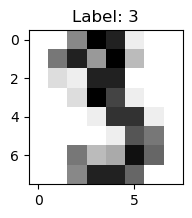

In [142]:
digits = load_digits()

# Affichage des informations sur les données
print("Description des données :", digits['DESCR'])

# Affichage d'une image exemple
plt.figure(figsize=(2, 2))
plt.imshow(digits.images[3], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title(f'Label: {digits.target[3]}')
plt.show()

### Histogramme de classe

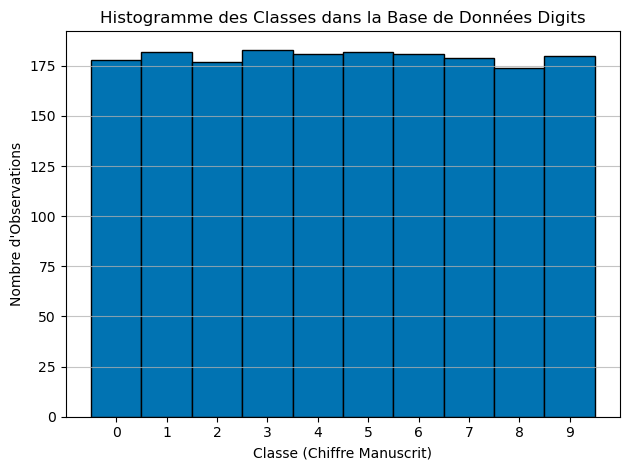

In [144]:
plt.hist(digits.target, bins=np.arange(11) - 0.5, edgecolor='black')
plt.title('Histogramme des Classes dans la Base de Données Digits')
plt.xlabel('Classe (Chiffre Manuscrit)')
plt.ylabel('Nombre d\'Observations')
plt.xticks(range(10))  
plt.grid(axis='y', alpha=0.75)  # Grille horizontale plus légère
plt.tight_layout()  # Ajustement automatique pour une meilleure présentation
plt.show()

### Division de l'échantillon et application du k-NN

In [147]:
# Division des données en ensembles d'apprentissage et de test (répartition 50-50)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5, random_state=0)

# Création et entraînement du modèle kNN, avec un nombre de voisins k = 30 (comme demandé dans l'énoncé)
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

# Prédiction et calcul du taux d'erreur
y_pred = knn.predict(X_test)
error_rate = 1 - accuracy_score(y_test, y_pred)
print(f"Taux d'erreur pour k={k} : {error_rate}")

Taux d'erreur pour k=50 : 0.05450500556173521


Le taux d'erreur obtenu est d'environ 5.45% (0.05450500556173521). En d'autres termes, le modèle a correctement prédit les étiquettes pour environ 94.55% des points de données dans l'ensemble de test.

## 13. Estimation de la matrice de confusion 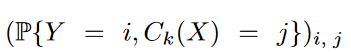

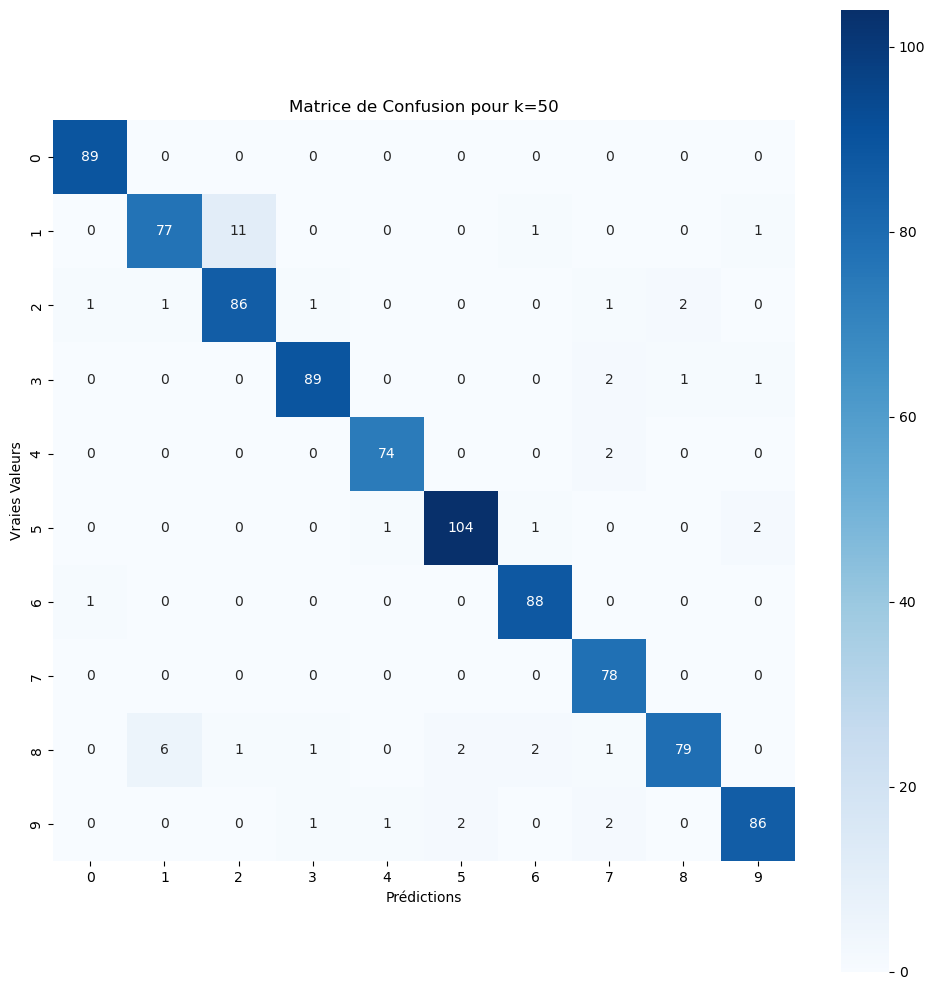

In [149]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec la barre de couleur
plt.figure(figsize=(10, 10))  # Ajustez selon vos besoins pour une meilleure lisibilité
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.title(f'Matrice de Confusion pour k={k}')
plt.tight_layout()  # Ajuste automatiquement la taille de la figure pour que tout soit bien ajusté
plt.show()

### Explication théorique

La formule au-dessus représente la probabilité conditionnelle que Y (la classe ou l'étiquette réelle d'un point de données) soit égale à une certaine valeur i, étant donné que le classificateur Ck(X) (une fonction de classification basée sur les caractéristiques X et le nombre de voisins k dans le cas de k-NN) prédit la classe j. i est une valeur de la vraie étiquette, tandis que j est une valeur de la classe prédite.

### Explication empirique

Dans la pratique, la probabilité conditionnelle aide à évaluer la précision de la classification pour chaque classe et à identifier les erreurs systématiques que le classificateur pourrait faire. Pour plus d'interprétation, elle fait l'objet d'une présentation matricielle. 

Dans la matrice, chaque cellule indique le nombre de prédictions pour chaque combinaison de classe réelle (ligne) et classe prédite (colonne). Il faut préciser que la confusion de matrice ne contienne pas directement les valeurs des probabilités conditionnelles. C'est plutôt des valeurs absolues. Malgré celà, les probabilités conditionnelles peuvent être dérivées de la matrice de confusion en normalisant les valeurs de chaque ligne ou colonne pour qu'elles somment à 1. 

Les valeurs sur la diagonale principale de la matrice représentent le nombre de prédictions correctes pour chaque classe. Par exemple, il y a 89 instances correctement prédites comme étant de la classe 0, 77 de la classe 1, et ainsi de suite. Ces valeurs sont ce que l'on appelle les "vrais positifs" pour chaque classe. Ces vraies positifs sont très intenses si l'on se base sur les couleurs.

Les valeurs qui ne sont pas sur la diagonale principale représentent les erreurs de classification. Dans ces zones, il y a 11 instances de la classe 1 qui ont été incorrectement classées comme étant de la classe 2. Ces erreurs sont appelées "faux positifs" pour la classe prédite et "faux négatifs" pour la classe réelle. Mais il n'y a pas beaucoup de valeurs élevés dans ce zone là. 

En examinant la répartition des couleurs, on peut juger de la performance générale du modèle. Une forte concentration de valeurs foncées sur la diagonale par rapport aux valeurs hors diagonale suggère une meilleure performance.

## 14.proposition d'une méthode pour choisir k et la mettre en oeuvre

Taux d'erreur pour k=1 : 0.011686143572620988
Taux d'erreur pour k=6 : 0.013912075681691727
Taux d'erreur pour k=11 : 0.015581524763494725
Taux d'erreur pour k=16 : 0.01947690595436835
Taux d'erreur pour k=21 : 0.023372287145242088
Taux d'erreur pour k=26 : 0.028380634390651083
Taux d'erreur pour k=31 : 0.03227601558152471
Taux d'erreur pour k=36 : 0.03283249860879245
Taux d'erreur pour k=41 : 0.036727879799666074
Taux d'erreur pour k=46 : 0.036171396772398445
Taux d'erreur pour k=100 : 0.07122982749026152
Taux d'erreur pour k=200 : 0.1012799109627156


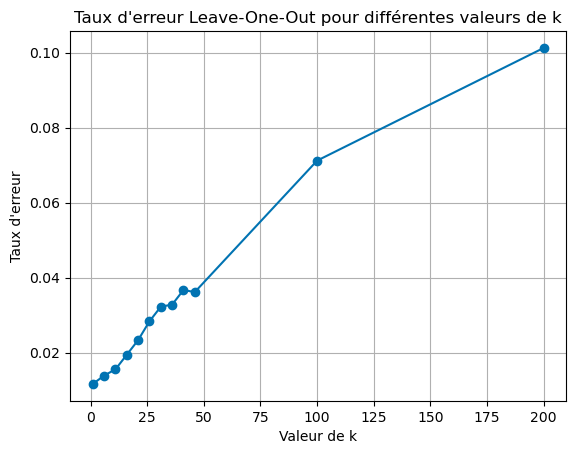

In [152]:
# Charger les données
digits = load_digits()

# Définir les valeurs de k à tester
k_values = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]

# Initialiser la liste pour stocker les taux d'erreur
error_rates = []

# Initialiser le validateur Leave-One-Out
loo = LeaveOneOut()

# Boucle sur les différentes valeurs de k
for k in k_values:
    # Créer un classificateur k-NN avec la valeur actuelle de k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Liste pour stocker les scores de précision pour chaque fold de LOO
    scores = []
    
    # Exécuter la validation croisée Leave-One-Out
    for train_index, test_index in loo.split(digits.data):
        X_train, X_test = digits.data[train_index], digits.data[test_index]
        y_train, y_test = digits.target[train_index], digits.target[test_index]
        
        # Entraîner le modèle
        knn.fit(X_train, y_train)
        
        # Faire des prédictions
        y_pred = knn.predict(X_test)
        
        # Calculer l'exactitude
        scores.append(accuracy_score(y_test, y_pred))
    
    # Calculer le taux d'erreur moyen pour la valeur actuelle de k
    error_rate = 1 - np.mean(scores)
    error_rates.append(error_rate)
    
    # Imprimer le taux d'erreur pour la valeur actuelle de k
    print(f"Taux d'erreur pour k={k} : {error_rate}")

# Afficher la courbe d'erreur
plt.plot(k_values, error_rates, marker='o')
plt.title('Taux d\'erreur Leave-One-Out pour différentes valeurs de k')
plt.xlabel('Valeur de k')
plt.ylabel('Taux d\'erreur')
plt.grid(True)
plt.show()

# Pour aller plus loin